## Chaotic Mapping
Logistic map

In [ ]:
import numpy as np

def logistic_map_permutation(length, x0=0.387, r=3.99, burn_in=100):
    """
    Create a permutation of range(length) using a logistic map.
    Keys = (x0, r). Change them to get a different (keyed) order.
    """
    x = x0
    seq = []
    # Burn-in to remove transient
    for _ in range(burn_in):
        x = r * x * (1 - x)

    for _ in range(length):
        x = r * x * (1 - x)
        seq.append(x)

    seq = np.array(seq)
    # argsort gives an order from smallest -> largest; that’s our permutation
    perm = np.argsort(seq)
    return perm

def apply_permutation(arr, perm):
    """Permute a 1D array using the given permutation."""
    return arr[perm]

def invert_permutation(perm):
    """Compute inverse permutation to undo the shuffle."""
    inv = np.empty_like(perm)
    inv[perm] = np.arange(len(perm))
    return inv

In [ ]:
def chaotic_positions(h, w, K, x0=0.321, r=3.99):
    L = h * w
    perm = logistic_map_permutation(L, x0=x0, r=r)
    flat_indices = perm[:K]  # K embedding positions in a keyed order
    # map back to 2D coordinates
    rows = flat_indices // w
    cols = flat_indices % w
    return np.stack([rows, cols], axis=1)  # shape (K, 2)

gray image and bits

In [11]:
import numpy as np
from PIL import Image

def image_to_bits_bytes(path, size=None):
    """
    Returns:
      - bits: 1D uint8 array of {0,1} of length (H*W*8)
      - arr: 2D uint8 grayscale image (H,W)
    """
    img = Image.open(path).convert('L')
    if size is not None:
        img = img.resize(size, Image.BILINEAR)
    arr = np.array(img, dtype=np.uint8)  # HxW

    # view each pixel’s 8 bits (MSB…LSB)
    # shape: (H*W, 8)
    bytes_flat = arr.ravel()
    bits_per_byte = ((bytes_flat[:, None] & (1 << np.arange(7, -1, -1))) > 0).astype(np.uint8)
    bits = bits_per_byte.reshape(-1)
    return bits, arr

# Example
bits8, gray2d = image_to_bits_bytes("images/s.jpg", size=(64,64))
print(len(bits8), "bits total (H*W*8)")

32768 bits total (H*W*8)


In [15]:
bits8

array([1, 1, 1, ..., 1, 1, 1], shape=(32768,), dtype=uint8)

In [12]:
def bitplane_from_gray(arr, plane=7):
    """
    plane: 7=MSB, 0=LSB
    returns a 1D bit array
    """
    bp = ((arr >> plane) & 1).astype(np.uint8)
    return bp.ravel()

bp_msb = bitplane_from_gray(gray2d, plane=7)  # MSB bits

In [ ]:
def bits_to_gray_image(bits8, shape):
    """Inverse of image_to_bits_bytes (needs exactly H*W*8 bits)."""
    H, W = shape
    bits8 = np.asarray(bits8, dtype=np.uint8).reshape(-1, 8)
    vals = np.packbits(bits8, axis=1, bitorder='big')  # shape (H*W, 1)
    arr = vals.reshape(H, W)
    return arr

arr_round = bits_to_gray_image(bits8, gray2d.shape)

In [14]:
import cv2

cv2.imshow("Recovered Watermark", arr_round.astype('uint8'))
cv2.waitKey(0)
cv2.destroyAllWindows()

bit image with logistic map

In [16]:
perm = logistic_map_permutation(len(bits8))
scrambled = apply_permutation(bits8, perm)

print(scrambled)

# Later (extraction), to recover original:
inv = invert_permutation(perm)
recovered = scrambled[inv]
assert np.array_equal(recovered, bits8)

[1 0 1 ... 1 0 1]


In [20]:
import numpy as np
from PIL import Image
import cv2
import os

# -----------------------------
# Chaotic logistic map helpers
# -----------------------------
def logistic_sequence(n, r=3.99, x0=0.387, discard=200):
    """
    Generate n chaotic samples from the logistic map: x_{k+1} = r*x_k*(1-x_k)
    discard: burn-in iterations to skip the transient.
    """
    x = x0
    # burn-in
    for _ in range(discard):
        x = r * x * (1.0 - x)
    seq = np.empty(n, dtype=np.float64)
    for i in range(n):
        x = r * x * (1.0 - x)
        seq[i] = x
    return seq

def permutation_from_logistic(n, r=3.99, x0=0.387, discard=200):
    """
    Create a permutation of range(n) by sorting logistic values.
    Sorting indices by chaotic values gives a reproducible "random" permutation.
    """
    vals = logistic_sequence(n, r=r, x0=x0, discard=discard)
    perm = np.argsort(vals, kind="mergesort")  # stable sort for reproducibility
    return perm

def inverse_permutation(perm):
    inv = np.empty_like(perm)
    inv[perm] = np.arange(perm.size)
    return inv

# -----------------------------
# Pixel-level scrambling
# -----------------------------
def scramble_pixels(arr, r=3.99, x0=0.387):
    """
    Scramble along the first axis of a flattened array of bytes.
    Works for color or grayscale by flattening to a byte stream first.
    """
    flat = arr.reshape(-1)
    n = flat.size
    perm = permutation_from_logistic(n, r=r, x0=x0)
    scrambled = flat[perm].copy()
    return scrambled.reshape(arr.shape), perm

def descramble_pixels(arr, perm):
    flat = arr.reshape(-1)
    inv = inverse_permutation(perm)
    restored = flat[inv].copy()
    return restored.reshape(arr.shape)

# -----------------------------
# Bit-level scrambling
# -----------------------------
def to_bits(byte_array):
    return np.unpackbits(byte_array)

def from_bits(bits, shape_bytes):
    packed = np.packbits(bits)
    return packed.reshape(shape_bytes)

def scramble_bits(arr, r=3.99, x0=0.387):
    """
    Scramble at bit granularity (stronger diffusion).
    """
    flat_bytes = arr.reshape(-1)
    bits = to_bits(flat_bytes)
    nbits = bits.size
    perm = permutation_from_logistic(nbits, r=r, x0=x0)
    bits_scrambled = bits[perm].copy()
    bytes_scrambled = from_bits(bits_scrambled, flat_bytes.shape)
    return bytes_scrambled.reshape(arr.shape), perm

def descramble_bits(arr, perm):
    flat_bytes = arr.reshape(-1)
    bits = to_bits(flat_bytes)
    inv = inverse_permutation(perm)
    bits_restored = bits[inv].copy()
    bytes_restored = from_bits(bits_restored, flat_bytes.shape)
    return bytes_restored.reshape(arr.shape)

# -----------------------------
# PSNR (to confirm perfect restore)
# -----------------------------
def psnr(a, b):
    a = a.astype(np.float64)
    b = b.astype(np.float64)
    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return float('inf')
    PIX = 255.0
    return 20.0 * np.log10(PIX / np.sqrt(mse))

# -----------------------------
# IO helpers
# -----------------------------
def load_image_as_bytes(path):
    """
    Returns (byte_array, pil_mode, pil_size, original_dtype)
    byte_array is uint8 view of the image data (H,W[,C]).
    """
    img = Image.open(path).convert("RGB")  # force RGB for generality; change to 'L' for grayscale
    arr = np.array(img, dtype=np.uint8)
    return arr, img.mode, img.size, np.uint8

def save_image_from_bytes(arr, out_path):
    # If last dim is 3 assume RGB, else L
    if arr.ndim == 3 and arr.shape[2] == 3:
        Image.fromarray(arr, mode="RGB").save(out_path)
    else:
        Image.fromarray(arr.squeeze(), mode="L").save(out_path)

# -----------------------------
# Demo / usage
# -----------------------------
in_path = "images/s.jpg"
out_scrambled = "scrambled.png"
out_restored  = "restored.png"
use_bit_level = True               # True: bit-level; False: pixel-level
r  = 3.99                          # key part 1
x0 = 0.387                         # key part 2 (must be in (0,1) and not 0.25, 0.5, 0.75, etc.)

# Load
arr, mode, size, _ = load_image_as_bytes(in_path)

# Scramble
if use_bit_level:
    scrambled, perm = scramble_bits(arr, r=r, x0=x0)
else:
    scrambled, perm = scramble_pixels(arr, r=r, x0=x0)

# Save scrambled
# save_image_from_bytes(scrambled, out_scrambled)

# Reverse (descramble)
if use_bit_level:
    restored = descramble_bits(scrambled, perm)
else:
    restored = descramble_pixels(scrambled, perm)

# Save restored
# save_image_from_bytes(restored, out_restored)

# Check PSNR (should be inf for perfect recovery)
p = psnr(arr, restored)
print(f"Restoration PSNR: {p} dB (inf means identical)")

# show images
cv2.imshow("Scrambled Image", scrambled.astype('uint8'))
cv2.imshow("Restored Image", restored.astype('uint8'))
cv2.waitKey(0)

Restoration PSNR: inf dB (inf means identical)


-1

In [24]:
# pip install pillow numpy pywavelets matplotlib
import numpy as np
from PIL import Image
import pywt
import matplotlib.pyplot as plt

# ---------- Helpers: watermark <-> bits ----------
def img_to_bits(wm_img: Image.Image, thresh=128):
    """Convert a grayscale watermark image (0..255) to a 0/1 bit array."""
    wm = wm_img.convert("L")
    arr = np.array(wm)
    bits = (arr >= thresh).astype(np.uint8).ravel()
    return bits, arr.shape  # (bits, original HxW)

def bits_to_img(bits: np.ndarray, shape):
    """Back from 0/1 bits to a grayscale image (0 or 255)."""
    arr = (bits.reshape(shape) * 255).astype(np.uint8)
    return Image.fromarray(arr, mode="L")

# ---------- Logistic map permutation (reversible) ----------
def logistic_perm_indices(n, x0=0.712345, r=3.99):
    """
    Generate a permutation of range(n) using logistic map ordering.
    Returns perm indices and inverse perm indices.
    """
    x = np.empty(n, dtype=np.float64)
    x_val = x0
    # small burn-in to decorrelate initial conditions
    for _ in range(100):
        x_val = r * x_val * (1.0 - x_val)
    for i in range(n):
        x_val = r * x_val * (1.0 - x_val)
        x[i] = x_val
    perm = np.argsort(x, kind="mergesort")  # stable sort → deterministic
    inv = np.empty_like(perm)
    inv[perm] = np.arange(n)
    return perm, inv

def scramble_bits(bits, x0=0.712345, r=3.99):
    perm, inv = logistic_perm_indices(len(bits), x0=x0, r=r)
    return bits[perm], perm, inv

def descramble_bits(bits_scrambled, inv_perm):
    return bits_scrambled[inv_perm]

# ---------- DWT-LH embedding (QIM) ----------
def dwt_lh_embed(host_img: Image.Image, wm_bits: np.ndarray, wavelet="haar", step=8.0):
    """
    Embed wm_bits into LH subband using simple QIM.
    step: quantization step (bigger → more robust, smaller → more imperceptible)
    Returns stego image (PIL) and the number of bits actually embedded.
    """
    img = host_img.convert("L")
    I = np.asarray(img, dtype=np.float32)

    # single-level DWT
    LL, (LH, HL, HH) = pywt.dwt2(I, wavelet=wavelet)

    lh = LH.copy().ravel()
    n_cap = lh.size
    n = min(len(wm_bits), n_cap)

    # Simple QIM: force |coeff| into bins around step*(k + 0.25) for bit 0, or step*(k + 0.75) for bit 1
    # This uses residue modulo step to set bit.
    for i in range(n):
        c = lh[i]
        s = np.sign(c) if c != 0 else 1.0
        a = abs(c)
        r = a % step  # residue in [0, step)
        # target residues
        r0, r1 = 0.25 * step, 0.75 * step
        target = r0 if wm_bits[i] == 0 else r1
        a_new = a + (target - r)
        lh[i] = s * a_new

    # put back & inverse DWT
    LH_emb = lh.reshape(LH.shape)
    stego = pywt.idwt2((LL, (LH_emb, HL, HH)), wavelet=wavelet)

    # clip & convert
    stego = np.clip(stego, 0, 255).astype(np.uint8)
    return Image.fromarray(stego, mode="L"), n

def dwt_lh_extract(stego_img: Image.Image, nbits: int, wavelet="haar", step=8.0):
    """
    Extract nbits from LH subband using the same QIM rule.
    """
    I = np.asarray(stego_img.convert("L"), dtype=np.float32)
    LL, (LH, HL, HH) = pywt.dwt2(I, wavelet=wavelet)

    lh = LH.ravel()
    n = min(nbits, lh.size)
    bits = np.zeros(n, dtype=np.uint8)

    for i in range(n):
        c = lh[i]
        a = abs(c)
        r = a % step
        # Decide by which bin the residue is closer to
        bits[i] = 1 if abs(r - 0.75 * step) < abs(r - 0.25 * step) else 0

    return bits

C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_7520\2071862900.py:82: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(stego, mode="L"), n
C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_7520\2071862900.py:18: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


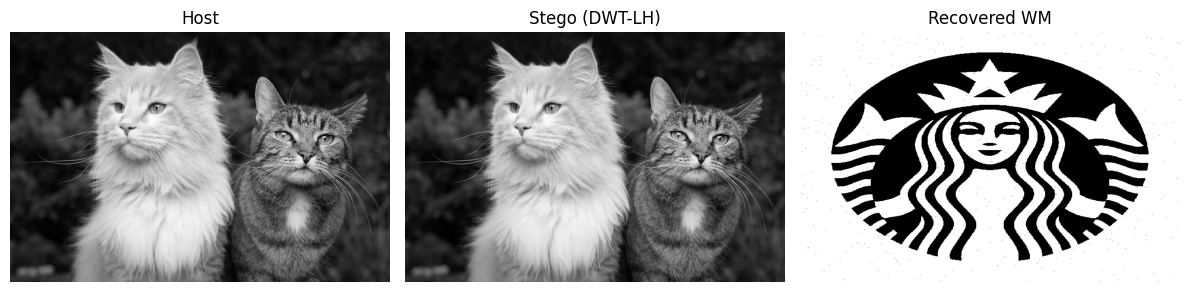

In [26]:
import matplotlib.pyplot as plt

# --- Paths (replace with your own) ---
host_path = "images/cat.webp"
watermark_path = "images/s.jpg"

# Load images
host = Image.open(host_path).convert("L")
wm_img = Image.open(watermark_path).convert("L")

# Optionally resize watermark to fit capacity (LH has about 1/4 of pixels of host)
# Example: set watermark size to min(host.size)//2 in each dimension
target_w = min(host.size[0]//2, wm_img.size[0])
target_h = min(host.size[1]//2, wm_img.size[1])
wm_img = wm_img.resize((target_w, target_h), Image.NEAREST)

# 1) watermark -> bits
wm_bits, wm_shape = img_to_bits(wm_img)

# 2) scramble (logistic map)
x0, r = 0.712345, 3.99
wm_bits_scrambled, perm, inv_perm = scramble_bits(wm_bits, x0=x0, r=r)

# 3) embed in LH of DWT
wavelet = "haar"   # or 'db2', 'bior1.3', etc.
step = 8.0         # tune: 6–12 is a reasonable starting range
stego, used = dwt_lh_embed(host, wm_bits_scrambled, wavelet=wavelet, step=step)

# 4) extract
rec_bits_scrambled = dwt_lh_extract(stego, used, wavelet=wavelet, step=step)

stego.save("stego_image.png")  # Save stego image

# 5) descramble
rec_bits = descramble_bits(rec_bits_scrambled, inv_perm)

# 6) rebuild watermark image (pad if we embedded fewer bits than original)
if used < wm_bits.size:
    # If not all bits fit, only the first 'used' were embedded
    reconstructed = bits_to_img(rec_bits, (wm_shape[0]*wm_shape[1],))  # will error; handle partial properly
    # Proper handling:
    rec_full = np.zeros_like(wm_bits, dtype=np.uint8)
    rec_full[:used] = rec_bits
    wm_rec_img = bits_to_img(rec_full, wm_shape)
else:
    wm_rec_img = bits_to_img(rec_bits, wm_shape)

# --- Visualize ---
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(host, cmap="gray"); axs[0].set_title("Host"); axs[0].axis("off")
axs[1].imshow(stego, cmap="gray"); axs[1].set_title("Stego (DWT-LH)"); axs[1].axis("off")
axs[2].imshow(wm_rec_img, cmap="gray"); axs[2].set_title("Recovered WM"); axs[2].axis("off")
plt.tight_layout(); plt.show()

C:\Users\Vin Sen\AppData\Local\Temp\ipykernel_7520\2071862900.py:18: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr, mode="L")


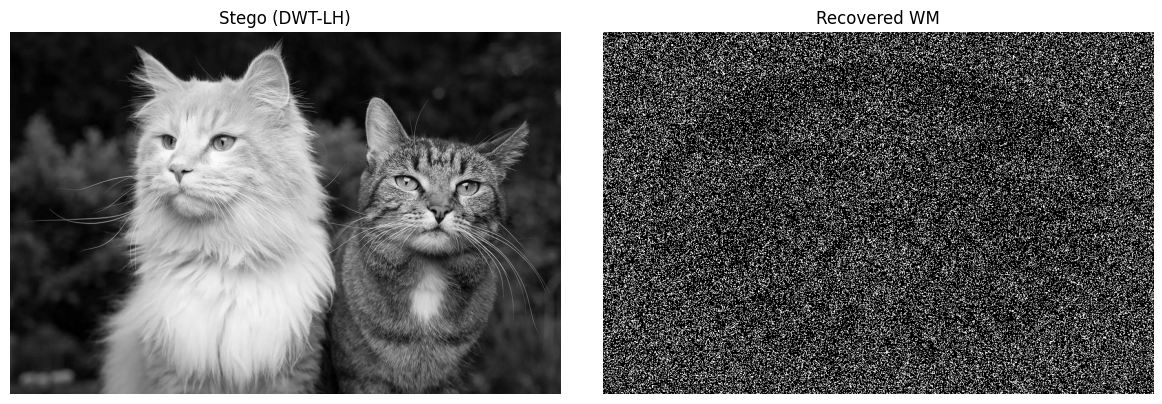

In [28]:
stego =  Image.open("images/a.png").convert("L")

rec_bits_scrambled = dwt_lh_extract(stego, used, wavelet=wavelet, step=step)

# 5) descramble
rec_bits = descramble_bits(rec_bits_scrambled, inv_perm)

# 6) rebuild watermark image (pad if we embedded fewer bits than original)
if used < wm_bits.size:
    # If not all bits fit, only the first 'used' were embedded
    reconstructed = bits_to_img(rec_bits, (wm_shape[0]*wm_shape[1],))  # will error; handle partial properly
    # Proper handling:
    rec_full = np.zeros_like(wm_bits, dtype=np.uint8)
    rec_full[:used] = rec_bits
    wm_rec_img = bits_to_img(rec_full, wm_shape)
else:
    wm_rec_img = bits_to_img(rec_bits, wm_shape)

# --- Visualize ---
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(stego, cmap="gray"); axs[0].set_title("Stego (DWT-LH)"); axs[0].axis("off")
axs[1].imshow(wm_rec_img, cmap="gray"); axs[1].set_title("Recovered WM"); axs[1].axis("off")
plt.tight_layout(); plt.show()

In [29]:
"""
Modular Blind Image Watermarking Pipeline
-----------------------------------------
Goal: Robust to JPEG compression, small resize, small rotation, small cropping.
Constraints: 
  - Host image: color (not resized at embed time)
  - Watermark image: monochrome, fixed size (e.g., 64x64)
  - Blind extraction (only watermarked image + fixed private key)
  - Each step is swappable with minimal changes (Strategy pattern)

Dependencies: numpy, pillow (PIL), pywt
Install (if needed):
    pip install numpy pillow pywavelets

Usage (example at bottom):
    wm = Watermarker(Config(...))
    watermarked_rgb = wm.embed(host_rgb, watermark_img)
    recovered_wm = wm.extract(watermarked_rgb)

To swap components, pass alternative concrete classes implementing the 
respective interfaces into Config (e.g., QIMDitherEmbedder → SpreadSpectrumEmbedder).
"""

from __future__ import annotations
import hashlib
import math
from dataclasses import dataclass, field
from typing import Tuple, Dict, List, Sequence, Optional
import numpy as np
from PIL import Image
import pywt

# ---------------------------
# Utility & Common Components
# ---------------------------

def sha256_int(s: str) -> int:
    return int(hashlib.sha256(s.encode('utf-8')).hexdigest(), 16) & ((1<<63)-1)

class RandomStream:
    """Keyed PRNG wrapper using numpy Generator; deterministic across components."""
    def __init__(self, key: str, domain: str):
        seed = sha256_int(key + "|" + domain)
        self.rng = np.random.default_rng(seed)

    def integers(self, low: int, high: int, size=None) -> np.ndarray:
        return self.rng.integers(low, high, size=size)

    def choice(self, a, size=None, replace=True, p=None):
        return self.rng.choice(a, size=size, replace=replace, p=p)

    def permutation(self, n: int) -> np.ndarray:
        return self.rng.permutation(n)

    def normal(self, loc=0.0, scale=1.0, size=None) -> np.ndarray:
        return self.rng.normal(loc, scale, size)

    def random(self, size=None) -> np.ndarray:
        return self.rng.random(size)

# ---------------------------
# Color Space Adapter
# ---------------------------

class ColorAdapter:
    """Interface: convert RGB<->work space. Work space must be float32 [0,1]."""
    def to_work(self, rgb: np.ndarray) -> Tuple[np.ndarray, Dict]:
        raise NotImplementedError
    def from_work(self, work: np.ndarray, ctx: Dict) -> np.ndarray:
        raise NotImplementedError

class YCbCrLumaAdapter(ColorAdapter):
    """
    Work channel is Y (luma) float32 [0,1]. Cb/Cr are preserved and re-attached.
    """
    def to_work(self, rgb: np.ndarray) -> Tuple[np.ndarray, Dict]:
        rgb = np.clip(rgb, 0, 255).astype(np.float32) / 255.0
        R, G, B = rgb[...,0], rgb[...,1], rgb[...,2]
        # BT.601 YCbCr
        Y  = 0.299*R + 0.587*G + 0.114*B
        Cb = (B - Y) * 0.564 + 0.5
        Cr = (R - Y) * 0.713 + 0.5
        ctx = {'Cb': Cb, 'Cr': Cr, 'shape': rgb.shape}
        return Y.astype(np.float32), ctx

    def from_work(self, Y: np.ndarray, ctx: Dict) -> np.ndarray:
        Cb, Cr = ctx['Cb'], ctx['Cr']
        # Inverse BT.601
        R = Y + 1.403*(Cr - 0.5)
        G = Y - 0.344*(Cb - 0.5) - 0.714*(Cr - 0.5)
        B = Y + 1.773*(Cb - 0.5)
        rgb = np.stack([R, G, B], axis=-1)
        rgb = np.clip(rgb, 0.0, 1.0)
        return (rgb * 255.0 + 0.5).astype(np.uint8)

# ---------------------------
# Watermark Bit I/O
# ---------------------------

def image_to_bits_01(img_gray_u8: np.ndarray, thresh: int = 128) -> np.ndarray:
    """Convert monochrome image to {0,1} bits row-major."""
    return (img_gray_u8.flatten() >= thresh).astype(np.uint8)

def bits_to_image_01(bits: np.ndarray, shape: Tuple[int,int]) -> np.ndarray:
    """Convert {0,1} bits to uint8 image (0 or 255)."""
    arr = (bits.reshape(shape).astype(np.uint8) * 255)
    return arr

# ---------------------------
# ECC + Interleave + Scramble
# ---------------------------

class WatermarkCoder:
    """Interface for bit-level preprocessing and postprocessing."""
    def encode(self, bits01: np.ndarray) -> np.ndarray:
        raise NotImplementedError
    def decode(self, llr: np.ndarray) -> np.ndarray:
        """Return hard-decoded {0,1} bits; assumes internal deinterleave/descramble."""
        raise NotImplementedError

class RepetitionInterleaveCoder(WatermarkCoder):
    """
    Simple, dependency-free coder:
      - Append CRC-32 (32 bits)
      - Random permutation (scramble)
      - Repeat each bit 'rep' times (interleaving friendly)
      - Random interleave (permute positions)
    Decoding:
      - Deinterleave
      - Majority vote per group for LLR (sum LLRs)
      - Descramble
      - Verify CRC; if fail, still return best-effort bits (without raising).
    This is a placeholder for BCH/LDPC; drop-in replaceable via interface.
    """
    def __init__(self, key: str, rep: int = 4):
        assert rep >= 2
        self.key = key
        self.rep = rep
        self._perm_scramble = None
        self._perm_interleave = None
        self._orig_len = None

    @staticmethod
    def crc32(bits01: np.ndarray) -> np.ndarray:
        import zlib
        byte_arr = np.packbits(bits01.astype(np.uint8))
        crc = zlib.crc32(byte_arr) & 0xffffffff
        return np.unpackbits(np.array([crc], dtype='>u4').view(np.uint8))

    @staticmethod
    def crc32_check(bits01: np.ndarray) -> bool:
        data, crc_bits = bits01[:-32], bits01[-32:]
        return np.array_equal(RepetitionInterleaveCoder.crc32(data), crc_bits)

    def encode(self, bits01: np.ndarray) -> np.ndarray:
        self._orig_len = len(bits01)
        with_crc = np.concatenate([bits01, self.crc32(bits01)])
        # scramble
        rs = RandomStream(self.key, "coder_scramble")
        self._perm_scramble = rs.permutation(len(with_crc))
        scrambled = with_crc[self._perm_scramble]
        # repetition
        repeated = np.repeat(scrambled, self.rep)
        # interleave
        rs2 = RandomStream(self.key, "coder_interleave")
        self._perm_interleave = rs2.permutation(len(repeated))
        interleaved = repeated[self._perm_interleave]
        return interleaved.astype(np.uint8)

    def decode(self, llr: np.ndarray) -> np.ndarray:
        # deinterleave
        inv_inter = np.empty_like(self._perm_interleave)
        inv_inter[self._perm_interleave] = np.arange(len(self._perm_interleave))
        deinter = llr[inv_inter]
        # group by repetition
        groups = deinter.reshape(-1, self.rep)
        # majority via LLR sum (positive means bit=1 more likely)
        group_llr = groups.sum(axis=1)
        hard_groups = (group_llr >= 0).astype(np.uint8)
        # descramble
        inv_scr = np.empty_like(self._perm_scramble)
        inv_scr[self._perm_scramble] = np.arange(len(self._perm_scramble))
        descrambled = hard_groups[inv_scr]
        data_with_crc = descrambled
        # CRC verify (best-effort)
        data_bits = data_with_crc[:-32]
        # If CRC fails, still return best effort
        return data_bits.astype(np.uint8)

# ---------------------------
# Transform / Subbands
# ---------------------------

class Transform:
    """Interface: forward/inverse on single-channel float32 [0,1]."""
    def forward(self, Y: np.ndarray) -> Dict[str, np.ndarray]:
        raise NotImplementedError
    def inverse(self, coeffs: Dict[str, np.ndarray]) -> np.ndarray:
        raise NotImplementedError

class DWT2LTransform(Transform):
    """
    2-level DWT with selectable wavelet. Outputs dict of subbands:
      L1: LL1, LH1, HL1, HH1
      L2: LL2, LH2, HL2, HH2  (where LL2 is DWT of LL1)
    """
    def __init__(self, wavelet: str = "db2", mode: str = "periodization"):
        self.wavelet = wavelet
        self.mode = mode

    def forward(self, Y: np.ndarray) -> Dict[str, np.ndarray]:
        c = {}
        coeffs1 = pywt.dwt2(Y, self.wavelet, mode=self.mode)
        LL1, (LH1, HL1, HH1) = coeffs1
        coeffs2 = pywt.dwt2(LL1, self.wavelet, mode=self.mode)
        LL2, (LH2, HL2, HH2) = coeffs2
        c['LL2'], c['LH2'], c['HL2'], c['HH2'] = LL2, LH2, HL2, HH2
        c['LH1'], c['HL1'], c['HH1'] = LH1, HL1, HH1
        c['LL1_shape'] = LL1.shape  # store for inverse
        return c

    def inverse(self, c: Dict[str, np.ndarray]) -> np.ndarray:
        LL2, (LH2, HL2, HH2) = c['LL2'], (c['LH2'], c['HL2'], c['HH2'])
        LL1 = pywt.idwt2((LL2, (LH2, HL2, HH2)), self.wavelet, mode=self.mode)
        # ensure sizes exactly match stored shape (due to mode)
        H, W = c['LL1_shape']
        LL1 = LL1[:H, :W]
        Y = pywt.idwt2((LL1, (c['LH1'], c['HL1'], c['HH1'])), self.wavelet, mode=self.mode)
        return Y

# ---------------------------
# Carrier Selection & Mapping
# ---------------------------

@dataclass
class CarrierMap:
    """Holds mapping of bit indices to locations within subbands."""
    # For each bit index, list of carriers [(band, y, x, block_h, block_w)] replicated/tiling
    bit_to_carriers: List[List[Tuple[str, int, int, int, int]]]
    block_size: int

class CarrierSelector:
    """Interface: choose where to embed bits."""
    def select(self, coeffs: Dict[str, np.ndarray], n_bits: int, key: str) -> CarrierMap:
        raise NotImplementedError

class VarianceTiledSelector(CarrierSelector):
    """
    Select blocks with sufficient variance in chosen mid-bands and tile/replicate
    so that each bit maps to K carriers spread spatially.
    """
    def __init__(self, bands: Sequence[str] = ("LH1","HL1","LH2","HL2"), 
                 block_size: int = 16, replicas_per_bit: int = 4, min_var: float = 1e-5):
        self.bands = bands
        self.block_size = block_size
        self.replicas_per_bit = replicas_per_bit
        self.min_var = min_var

    def _blocks_coords(self, H: int, W: int) -> List[Tuple[int,int]]:
        coords = []
        for y in range(0, H - self.block_size + 1, self.block_size):
            for x in range(0, W - self.block_size + 1, self.block_size):
                coords.append((y, x))
        return coords

    def select(self, coeffs: Dict[str, np.ndarray], n_bits: int, key: str) -> CarrierMap:
        candidates = []
        # collect blocks with variance above threshold across bands
        for b in self.bands:
            band = coeffs[b]
            H, W = band.shape
            coords = self._blocks_coords(H, W)
            for (y,x) in coords:
                blk = band[y:y+self.block_size, x:x+self.block_size]
                if float(blk.var()) >= self.min_var:
                    candidates.append((b, y, x, self.block_size, self.block_size))
        if len(candidates) < n_bits * self.replicas_per_bit:
            # fallback: allow low-variance
            pass
        rs = RandomStream(key, "carrier_select")
        rs_indices = rs.permutation(len(candidates))
        selected = [candidates[i] for i in rs_indices[: n_bits * self.replicas_per_bit]]
        # group into bit_to_carriers
        bit_to_carriers = []
        for i in range(n_bits):
            bit_to_carriers.append(selected[i*self.replicas_per_bit:(i+1)*self.replicas_per_bit])
        return CarrierMap(bit_to_carriers=bit_to_carriers, block_size=self.block_size)

# ---------------------------
# Synchronization Template (Pilots)
# ---------------------------

class Synchronizer:
    """
    Interface for R/S/T synchronization pilots.
    embed_pilots(Y) -> (Y_with_pilots, meta)
    align(Y_attacked) -> (Y_aligned, meta_out)
    Default implementation embeds faint sinusoid lattice (LL1 via transform)
    and a Fourier magnitude ring. The align() provided here is a NO-OP (identity),
    serving as a pluggable point to swap with a real estimator (e.g., Fourier–Mellin).
    """
    def embed_pilots(self, Y: np.ndarray, key: str) -> Tuple[np.ndarray, Dict]:
        raise NotImplementedError
    def align(self, Y: np.ndarray, key: str) -> Tuple[np.ndarray, Dict]:
        raise NotImplementedError

class SimplePilots(Synchronizer):
    def __init__(self, lattice_amp: float = 0.0025, ring_amp: float = 0.0025):
        self.lattice_amp = lattice_amp
        self.ring_amp = ring_amp
        self.tr = DWT2LTransform()

    def embed_pilots(self, Y: np.ndarray, key: str) -> Tuple[np.ndarray, Dict]:
        # Embed faint sinusoids in LL1 (via DWT)
        coeffs = self.tr.forward(Y)
        # reconstruct LL1 from level-2
        LL1 = pywt.idwt2((coeffs['LL2'], (coeffs['LH2'], coeffs['HL2'], coeffs['HH2'])),
                         self.tr.wavelet, mode=self.tr.mode)
        H, W = LL1.shape
        rs = RandomStream(key, "pilot")
        # two sinusoidal gratings
        f1 = max(2, W // 24)
        f2 = max(2, W // 16)
        xx, yy = np.meshgrid(np.arange(W), np.arange(H))
        phase1 = rs.random() * 2*np.pi
        phase2 = rs.random() * 2*np.pi
        lattice = (np.sin(2*np.pi*xx/f1 + phase1) + np.sin(2*np.pi*yy/f2 + phase2)) * self.lattice_amp
        LL1_p = LL1 + lattice.astype(np.float32)
        # pack back to level-2
        LL2, (LH2, HL2, HH2) = pywt.dwt2(LL1_p, self.tr.wavelet, mode=self.tr.mode)
        coeffs['LL2'], coeffs['LH2'], coeffs['HL2'], coeffs['HH2'] = LL2, LH2, HL2, HH2

        Yp = self.tr.inverse(coeffs)

        # Add a faint ring in Fourier magnitude (global)
        F = np.fft.fft2(Yp)
        Fm, Fa = np.abs(F), np.angle(F)
        cy, cx = np.array(Fm.shape)//2
        Ysz = min(cy, cx)
        r0 = int(0.30 * Ysz)
        w = max(2, int(0.01 * Ysz))
        yy2, xx2 = np.ogrid[:Fm.shape[0], :Fm.shape[1]]
        ring = ((yy2-cy)**2 + (xx2-cx)**2)
        mask = (ring >= (r0-w)**2) & (ring <= (r0+w)**2)
        Fm = Fm * (1.0 + self.ring_amp*mask.astype(np.float32))
        Fp = Fm * np.exp(1j*Fa)
        Ypp = np.real(np.fft.ifft2(Fp)).astype(np.float32)
        return Ypp, {'note': 'simple_pilots'}

    def align(self, Y: np.ndarray, key: str) -> Tuple[np.ndarray, Dict]:
        # NO-OP aligner. Swap with Fourier–Mellin or keypoint-based aligner for real robustness.
        return Y, {'note': 'identity_alignment'}

# ---------------------------
# Embedders (QIM, Spread Spectrum)
# ---------------------------

class Embedder:
    """Interface: embed/extract LLR on selected carriers."""
    def embed(self, coeffs: Dict[str, np.ndarray], cmap: CarrierMap, bits01: np.ndarray, key: str) -> Dict[str, np.ndarray]:
        raise NotImplementedError
    def extract_llr(self, coeffs: Dict[str, np.ndarray], cmap: CarrierMap, key: str) -> np.ndarray:
        raise NotImplementedError

class QIMDitherEmbedder(Embedder):
    """
    Dithered QIM on block-mean of mid-band coefficients (energy-normalized).
    Each carrier location corresponds to a block; we quantize the average value.
    LLR based on distance to 0/1 quantizers.
    """
    def __init__(self, delta: float = 0.02, dither_scale: float = 0.5):
        self.delta = float(delta)
        self.dither_scale = float(dither_scale)

    def _block_stat(self, band: np.ndarray, y: int, x: int, h: int, w: int) -> float:
        return float(band[y:y+h, x:x+w].mean())

    def _apply_block_offset(self, band: np.ndarray, y: int, x: int, h: int, w: int, offset: float):
        band[y:y+h, x:x+w] += offset

    def _dither(self, key: str, idx: int) -> float:
        rs = RandomStream(key, f"qim_dither_{idx}")
        # zero-mean dither in [-0.5,0.5]*delta*dither_scale
        return (rs.random() - 0.5) * self.delta * self.dither_scale

    def embed(self, coeffs: Dict[str, np.ndarray], cmap: CarrierMap, bits01: np.ndarray, key: str) -> Dict[str, np.ndarray]:
        c = {k: (v.copy() if isinstance(v, np.ndarray) else v) for k,v in coeffs.items()}
        idx = 0
        for bit_i, carriers in enumerate(cmap.bit_to_carriers):
            b = int(bits01[bit_i])
            for (band_name, y, x, h, w) in carriers:
                band = c[band_name]
                v = self._block_stat(band, y, x, h, w)
                d = self._dither(key, idx)
                # quantization centers for bit 0 and bit 1
                q0 = round((v - d) / self.delta) * self.delta + d
                q1 = q0 + (self.delta / 2.0)
                target = q1 if b == 1 else q0
                self._apply_block_offset(band, y, x, h, w, target - v)
                idx += 1
        return c

    def extract_llr(self, coeffs: Dict[str, np.ndarray], cmap: CarrierMap, key: str) -> np.ndarray:
        # produce LLR per bit by summing across replicas: log p(bit=1)/p(bit=0) ~ distance difference
        llrs = []
        idx = 0
        for carriers in cmap.bit_to_carriers:
            llr_sum = 0.0
            for (band_name, y, x, h, w) in carriers:
                band = coeffs[band_name]
                v = float(band[y:y+h, x:x+w].mean())
                d = self._dither(key, idx)
                # distances to nearest q0 and q1
                q0 = round((v - d) / self.delta) * self.delta + d
                q1 = q0 + (self.delta / 2.0)
                dist0 = abs(v - q0)
                dist1 = abs(v - q1)
                # LLR positive favors bit=1
                llr = (dist0 - dist1) / (self.delta/2.0 + 1e-8)
                llr_sum += llr
                idx += 1
            llrs.append(llr_sum)
        return np.array(llrs, dtype=np.float32)

class SpreadSpectrumEmbedder(Embedder):
    """
    Additive PN on block regions. LLR via correlation with PN.
    """
    def __init__(self, alpha: float = 0.15):
        self.alpha = float(alpha)

    def _block(self, band: np.ndarray, y: int, x: int, h: int, w: int) -> np.ndarray:
        return band[y:y+h, x:x+w]

    def embed(self, coeffs: Dict[str, np.ndarray], cmap: CarrierMap, bits01: np.ndarray, key: str) -> Dict[str, np.ndarray]:
        c = {k: (v.copy() if isinstance(v, np.ndarray) else v) for k,v in coeffs.items()}
        rs = RandomStream(key, "ss_pn")
        for bit_i, carriers in enumerate(cmap.bit_to_carriers):
            bit = 1 if bits01[bit_i] else -1
            for (band_name, y, x, h, w) in carriers:
                band = c[band_name]
                blk = self._block(band, y, x, h, w)
                pn = rs.normal(size=blk.shape).astype(np.float32)
                pn /= (np.linalg.norm(pn) + 1e-8)
                blk += self.alpha * bit * pn * np.sqrt(np.maximum(blk.var(), 1e-6))
        return c

    def extract_llr(self, coeffs: Dict[str, np.ndarray], cmap: CarrierMap, key: str) -> np.ndarray:
        rs = RandomStream(key, "ss_pn")
        llrs = []
        for carriers in cmap.bit_to_carriers:
            score = 0.0
            for (band_name, y, x, h, w) in carriers:
                band = coeffs[band_name]
                blk = band[y:y+h, x:x+w]
                pn = rs.normal(size=blk.shape).astype(np.float32)
                pn /= (np.linalg.norm(pn) + 1e-8)
                score += float((blk * pn).sum())
            llrs.append(score)
        return np.array(llrs, dtype=np.float32)

# ---------------------------
# Config & Orchestrator
# ---------------------------

@dataclass
class Config:
    key: str = "super_secret_key"
    color: ColorAdapter = field(default_factory=YCbCrLumaAdapter)
    coder: WatermarkCoder = field(default_factory=lambda: RepetitionInterleaveCoder(key="super_secret_key", rep=4))
    transform: Transform = field(default_factory=DWT2LTransform)
    selector: CarrierSelector = field(default_factory=lambda: VarianceTiledSelector(bands=("LH1","HL1","LH2","HL2"),
                                                                                     block_size=16, replicas_per_bit=6))
    synchronizer: Synchronizer = field(default_factory=SimplePilots)
    embedder: Embedder = field(default_factory=lambda: QIMDitherEmbedder(delta=0.02, dither_scale=0.5))
    pilot_strength_scale: float = 1.0  # keep for compatibility
    clip_minmax: Tuple[float,float] = (0.0, 1.0)

class Watermarker:
    def __init__(self, cfg: Config):
        # allow components to carry the same key if they need; we pass explicitly too
        self.cfg = cfg
        # ensure coder has right key if default factory used
        if isinstance(self.cfg.coder, RepetitionInterleaveCoder):
            self.cfg.coder.key = cfg.key

    # ---------- EMBED ----------
    def embed(self, host_rgb_u8: np.ndarray, wm_gray_u8: np.ndarray) -> np.ndarray:
        # 1) color conversion
        Y, color_ctx = self.cfg.color.to_work(host_rgb_u8.astype(np.uint8))

        # 2) pilots
        Yp, _ = self.cfg.synchronizer.embed_pilots(Y, self.cfg.key)

        # 3) watermark bits -> coded
        bits = image_to_bits_01(wm_gray_u8)
        coded = self.cfg.coder.encode(bits)

        # 4) transform
        coeffs = self.cfg.transform.forward(Yp)

        # 5) carrier selection (based on coeffs & coded length)
        cmap = self.cfg.selector.select(coeffs, n_bits=len(coded), key=self.cfg.key)

        # 6) embed (QIM/SS)
        coeffs_w = self.cfg.embedder.embed(coeffs, cmap, coded, self.cfg.key)

        # 7) inverse transform
        Yw = self.cfg.transform.inverse(coeffs_w)
        Yw = np.clip(Yw, *self.cfg.clip_minmax)

        # 8) back to RGB
        out_rgb = self.cfg.color.from_work(Yw, color_ctx)
        return out_rgb

    # ---------- EXTRACT ----------
    def extract(self, watermarked_rgb_u8: np.ndarray, wm_shape: Tuple[int,int]) -> np.ndarray:
        # 1) color
        Y, color_ctx = self.cfg.color.to_work(watermarked_rgb_u8.astype(np.uint8))

        # 2) align (RST) - identity in SimplePilots
        Ya, _ = self.cfg.synchronizer.align(Y, self.cfg.key)

        # 3) transform
        coeffs = self.cfg.transform.forward(Ya)

        # 4) carrier selection: must be deterministic (depends only on coeff stats + key)
        #    We need coded length to select. We don't know it explicitly here.
        #    Strategy: compute same length as in embed from wm_shape & coder.
        #    For RepetitionInterleaveCoder, length = (N+32)*rep after scramble & interleave.
        n_data = wm_shape[0]*wm_shape[1]
        if isinstance(self.cfg.coder, RepetitionInterleaveCoder):
            coded_len = (n_data + 32) * self.cfg.coder.rep
        else:
            raise ValueError("For custom coder, provide a decoding-length strategy.")

        cmap = self.cfg.selector.select(coeffs, n_bits=coded_len, key=self.cfg.key)

        # 5) extract LLRs from embedder
        llr = self.cfg.embedder.extract_llr(coeffs, cmap, self.cfg.key)

        # 6) decode (includes deinterleave/descramble/CRC check)
        decoded_bits = self.cfg.coder.decode(llr)

        # 7) reshape to image (truncate/pad)
        n_need = n_data
        if len(decoded_bits) < n_need:
            # pad if needed (shouldn't happen with proper coder)
            pad = np.zeros(n_need - len(decoded_bits), dtype=np.uint8)
            decoded_bits = np.concatenate([decoded_bits, pad])
        wm_bits = decoded_bits[:n_need]
        wm_img = bits_to_image_01(wm_bits, wm_shape)
        return wm_img

# ---------------------------
# Helper I/O (optional)
# ---------------------------

def load_rgb(path: str) -> np.ndarray:
    return np.array(Image.open(path).convert('RGB'))

def load_gray(path: str, size: Optional[Tuple[int,int]] = None) -> np.ndarray:
    im = Image.open(path).convert('L')
    if size is not None:
        im = im.resize(size, Image.BICUBIC)
    return np.array(im)

def save_image(path: str, arr: np.ndarray):
    Image.fromarray(arr).save(path)

In [30]:
# Example (replace paths as needed). This block demonstrates modularity.
# - To switch to Spread Spectrum: embedder=SpreadSpectrumEmbedder(alpha=0.2)
# - To switch transform: transform=DWT2LTransform(wavelet="bior4.4")
# - To change color space: implement new ColorAdapter and pass here.
# - To upgrade pilots: implement Synchronizer.align() and embed_pilots() accordingly.

host = load_rgb("images/cat.webp")          # color host (no resize at embed)
wm   = load_gray("images/s.jpg", (64,64))  # monochrome watermark 64x64

cfg = Config(
    key="my_private_key_001",
    color=YCbCrLumaAdapter(),
    coder=RepetitionInterleaveCoder(key="my_private_key_001", rep=6),
    transform=DWT2LTransform(wavelet="db2"),
    selector=VarianceTiledSelector(bands=("LH1","HL1","LH2","HL2"), block_size=16, replicas_per_bit=6),
    synchronizer=SimplePilots(lattice_amp=0.0025, ring_amp=0.0025),
    embedder=QIMDitherEmbedder(delta=0.025, dither_scale=0.5),
)

wm_engine = Watermarker(cfg)
watermarked = wm_engine.embed(host, wm)
# save_image("watermarked.png", watermarked)
cv2.imshow("Watermarked Image", watermarked)
cv2.waitKey(0)

-1

In [ ]:
# Blind extraction (only watermarked image + key + known watermark size)
recovered = wm_engine.extract(watermarked, wm_shape=(64,64))
# save_image("recovered_wm.png", recovered)

cv2.imshow("Recovered Watermark", recovered)
cv2.waitKey(0)

-1